# Google Colabを利用してますでしょうか？
以下のコードを実行してください。
- API_KEYを取得・書き換え
- [Upstage API](https://console.upstage.ai/api-keys)
- [WANDB API](https://wandb.ai/authorize)

In [ ]:
import os

# ===============================
# 🧪 weaveのインストール
# ===============================
print("📦 weave をインストール中...")
!pip install -q weave==0.52.9

# ===============================
# 🔑 APIキーの設定
# ===============================
# # https://console.upstage.ai/api-keys
os.environ["UPSTAGE_API_KEY"] = "YOUR_API_KEY"
print("🔐 Upstage APIキーを設定しました")

# https://wandb.ai/authorize (https://docs.wandb.ai/ja/support/find_api_key/ に解説があります)
os.environ["WANDB_API_KEY"] = "YOUR_API_KEY"
print("🔐 WANDB APIキーを設定しました")

# ===============================
# 📁 パス設定
# ===============================
ZIP_URL = "https://github.com/nhandsome-new/fc_2025_upstage_handson/raw/main/prep_google_colab/demo_imgs.zip"
ZIP_FILE = "demo_imgs.zip"
EXTRACT_DIR = "/content/demo_imgs"

# ===============================
# 📂 フォルダがあるかチェック
# ===============================
if not os.path.exists(EXTRACT_DIR):
    print("📂 フォルダが存在しません。初回セットアップを開始します...")

    # 🧭 1) 既存のフォルダ・ZIPファイルを削除（存在しなくてもOK）
    print("🧭 既存のフォルダ・ZIPファイルを削除中...")
    !rm -rf {EXTRACT_DIR} || true
    !rm -f {ZIP_FILE} || true

    # ⬇️ 2) wgetでZIPファイルをダウンロード
    print(f"⬇️ ZIPファイルをダウンロード中: {ZIP_URL}")
    !wget -q -O {ZIP_FILE} {ZIP_URL}
    print("✅ ダウンロード完了")

    # 📦 3) ZIPファイルを解凍
    print("📦 ZIPファイルを解凍中...")
    !unzip -q {ZIP_FILE} -d .
    print("✅ 解凍完了")

    # 🧼 4) ZIPファイルを削除
    print("🧼 ZIPファイルを削除中...")
    !rm {ZIP_FILE}
    print("✅ ZIPファイル削除完了")

else:
    print("✅ 既にフォルダが存在するため、ダウンロードと解凍はスキップします。")

# ===============================
# 📂 展開結果の確認
# ===============================
print(f"📂 展開結果の確認: {EXTRACT_DIR}")
!ls -l {EXTRACT_DIR}


In [ ]:
# ======================================================
# 📦 1. 必要なライブラリのインポート
# ======================================================
import weave
from weave import Content
import os
import re
import json
import requests
from datetime import datetime
from IPython.display import display, Image, HTML
from typing import Annotated

# ======================================================
# 🚀 2. Weaveの初期化
# ======================================================
weave.init("UPSTAGE-HANDSON-STEP3-NEW")

# ======================================================
# 🔐 3. APIキーの設定
# ======================================================
# os.environ["UPSTAGE_API_KEY"] = 'YOUR_API_KEY' # ← 実際のキーをここに入れる

# ======================================================
# ✅ 4. 初期化確認
# ======================================================
print("📚 ライブラリ準備完了!")
print("🎯 Weaveが初期化されました - すべての処理が自動追跡されます")
print(f"🔑 UPSTAGE_API_KEY: {'設定済み' if 'UPSTAGE_API_KEY' in os.environ and os.environ['UPSTAGE_API_KEY'] != 'YOUR_API_KEY' else '❌未設定'}")

# ======================================================
# 🧾 5. Document Parse 関数
# ======================================================
@weave.op()
def upstage_document_parse(file_path: Annotated[str, Content]) -> str:
    """
    📄 文書をHTMLに変換する関数
    - Upstage Document AI API を利用
    - ファイルを送信して OCR + HTML 化
    """
    # Step 1. APIキーを環境変数から取得
    api_key = os.environ.get("UPSTAGE_API_KEY")
    if not api_key:
        raise ValueError("❌ UPSTAGE_API_KEY が環境変数に設定されていません。")

    # Step 2. 画像ファイルをバイナリで読み込み
    with open(file_path, 'rb') as file:
        files = {
            "document": (os.path.basename(file_path), file, "image/jpeg")
        }
        data = {
            "model": "document-parse-nightly",
            "ocr": "auto",
            "output_formats": "html"
        }

        # Step 3. APIリクエスト送信
        response = requests.post(
            "https://api.upstage.ai/v1/document-ai/document-parse",
            headers={"Authorization": f"Bearer {api_key}"},
            files=files,
            data=data
        )

    # Step 4. 結果をJSONで取得してHTML部分を返す
    result = response.json()
    return result.get("content", {}).get("html", "")


# ======================================================
# ☀️ 6. LLM 応答生成関数
# ======================================================
@weave.op()
def upstage_solar_pro2(messages: list) -> str:
    """
    🧠 LLMで応答を生成する関数
    - Solar Pro2 モデルを使用
    - messages には system / user ロールのプロンプトを含む
    """
    # Step 1. APIキーを環境変数から取得
    api_key = os.environ.get("UPSTAGE_API_KEY")
    if not api_key:
        raise ValueError("❌ UPSTAGE_API_KEY が環境変数に設定されていません。")

    # Step 2. リクエストペイロードの構築
    payload = {
        "model": "syn-pro", # "solar-pro2",
        "messages": messages,
        "temperature": 0.7,
        "max_tokens": 16384,
        "reasoning_effort": "high",
    }

    # Step 3. APIリクエスト送信
    response = requests.post(
        "https://api.upstage.ai/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        },
        json=payload
    )

    # Step 4. 応答メッセージ部分のみを抽出して返す
    result = response.json()
    return result["choices"][0]["message"]["content"]


# ======================================================
# 🖼 7. ファイル情報の表示関数
# ======================================================
def display_document_info(file_path: str, title: str = ""):
    """
    📌 文書ファイルの基本情報を表示
    - ファイル名とサイズを出力
    - JPG/PNG形式の場合は画像を表示
    """
    if os.path.exists(file_path):
        # ファイル情報の出力
        print(f"\n📄 {title}")
        print(f"   ファイル名: {os.path.basename(file_path)}")
        print(f"   サイズ: {os.path.getsize(file_path):,} バイト")

        # 画像プレビュー（対応形式のみ）
        file_ext = os.path.splitext(file_path)[1].lower()
        if file_ext in ['.jpg', '.jpeg', '.png']:
            display(Image(file_path, width=300))
    else:
        print(f"❌ ファイルが見つかりません: {file_path}")

# ======================================================
# 🪜 8. JSON抽出関数
# ------------------------------------------------------
# - LLMの応答テキストから JSON フォーマット部分のみを抽出
# ======================================================
@weave.op()
def extract_json_from_llm_response(content: str):
    content = content.strip()
    match = re.search(r"```json\s*(\{[\s\S]*?\})\s*```", content)
    if match:
        content = match.group(1)
    return json.loads(content)


# ================================
# 🚀 メインパイプライン
# ================================

def process_document_pipeline(file_path: str, prompt1, prompt2, prompt3):
    # Step 1. ファイル情報の表示
    display_document_info(file_path, "対象文書")

    # Step 2. Document Parse
    print("\n📋 Document Parse中...")
    html_result = upstage_document_parse(file_path)

    # Step 3. LLMメッセージの組み立て
    messages = [
        {"role": "system", "content": "あなたはHTMLドキュメントを理解し、ユーザーの指示に従って処理します。必ず日本語で回答してください。"},
        {"role": "user", "content": f"# ドキュメント内容(HTML):\n{html_result}\n\n# プロンプト:\n{prompt1}"},
        {"role": "user", "content": f"前回結果をもとに次のタスク:\n{prompt2}"},
        {"role": "user", "content": f"前回結果をもとに次のタスク:\n{prompt3}"}
    ]

    # Step 4. LLM呼び出し
    print("\n🧠 LLM応答を生成中...")
    llm_result = upstage_solar_pro2(messages)

    # Step 5. JSON抽出
    print("\n📦 JSON抽出中...")
    try:
        result_json = extract_json_from_llm_response(llm_result)
        print("\n✅ 抽出結果（JSON）：")
        print(json.dumps(result_json, ensure_ascii=False, indent=2))
        return result_json
    except Exception as e:
        print(f"❌ JSON抽出に失敗しました: {e}")
        print("=== Raw LLM Result ===")
        print(llm_result)
        return None

# ================================
# ✨ 抽出プロンプト（自由に変更可能）
# ================================
PROMPT_1 = """
内容を変えずに、HTML内容を綺麗に整理して、新たなHTMLコードを作成してください。
- 必要な内容
  - 受傷者の情報
  - 受傷（事故）の情報
  - 免許証の情報
"""

PROMPT_2 = """
情報が明確に記載されていない場合は、「記載無し」 と記載してください。
不明確な推測は行わず、記載内容のみに基づいて抽出してください。

-「受傷者住所」は 番地を含めない
-「受傷の場所」は 番地を含める
- 日付は 西暦（YYYY/MM/DD） で表記する
-「受傷の原因」「受傷の内容」は抽出情報から分けて整理する
- 時刻は 24時間表記（HH:mm）
"""

PROMPT_3 = """
ドキュメント内容を見て、以下のフォーマットに従って JSON形式で標準化された情報を出力してください。

{
  "受傷者名前": "山田 太郎",
  "受傷者性別": "男",
  "受傷者生年月日": "1990/05/12",
  "受傷者住所": "福岡県福岡市中央区",
  "受傷の日時/日付": "2025/10/10",
  "受傷の日時/時間": "14:35",
  "受傷の場所": "福岡県福岡市博多区博多駅前3-4-5",
  "受傷の原因": "通勤中に段差で転倒",
  "受傷の内容": "右ひじ擦過傷",
  "飲酒の有無": "無",
  "警察の届出/有無": "有",
  "警察の届出/警察署名": "福岡警察署",
  "免許証番号": "123456789012",
  "免許証種類": "原付",
  "免許有効期間": "2027/05/12"
}
"""

weave: Logged in as Weights & Biases user: nhandsome.
weave: View Weave data at https://wandb.ai/nhandsome/UPSTAGE-HANDSON-STEP3-NEW/weave


📚 ライブラリ準備完了!
🎯 Weaveが初期化されました - すべての処理が自動追跡されます
🔑 UPSTAGE_API_KEY: 設定済み



📄 対象文書
   ファイル名: _Himawari_Accident_Report.jpg
   サイズ: 1,523,472 バイト


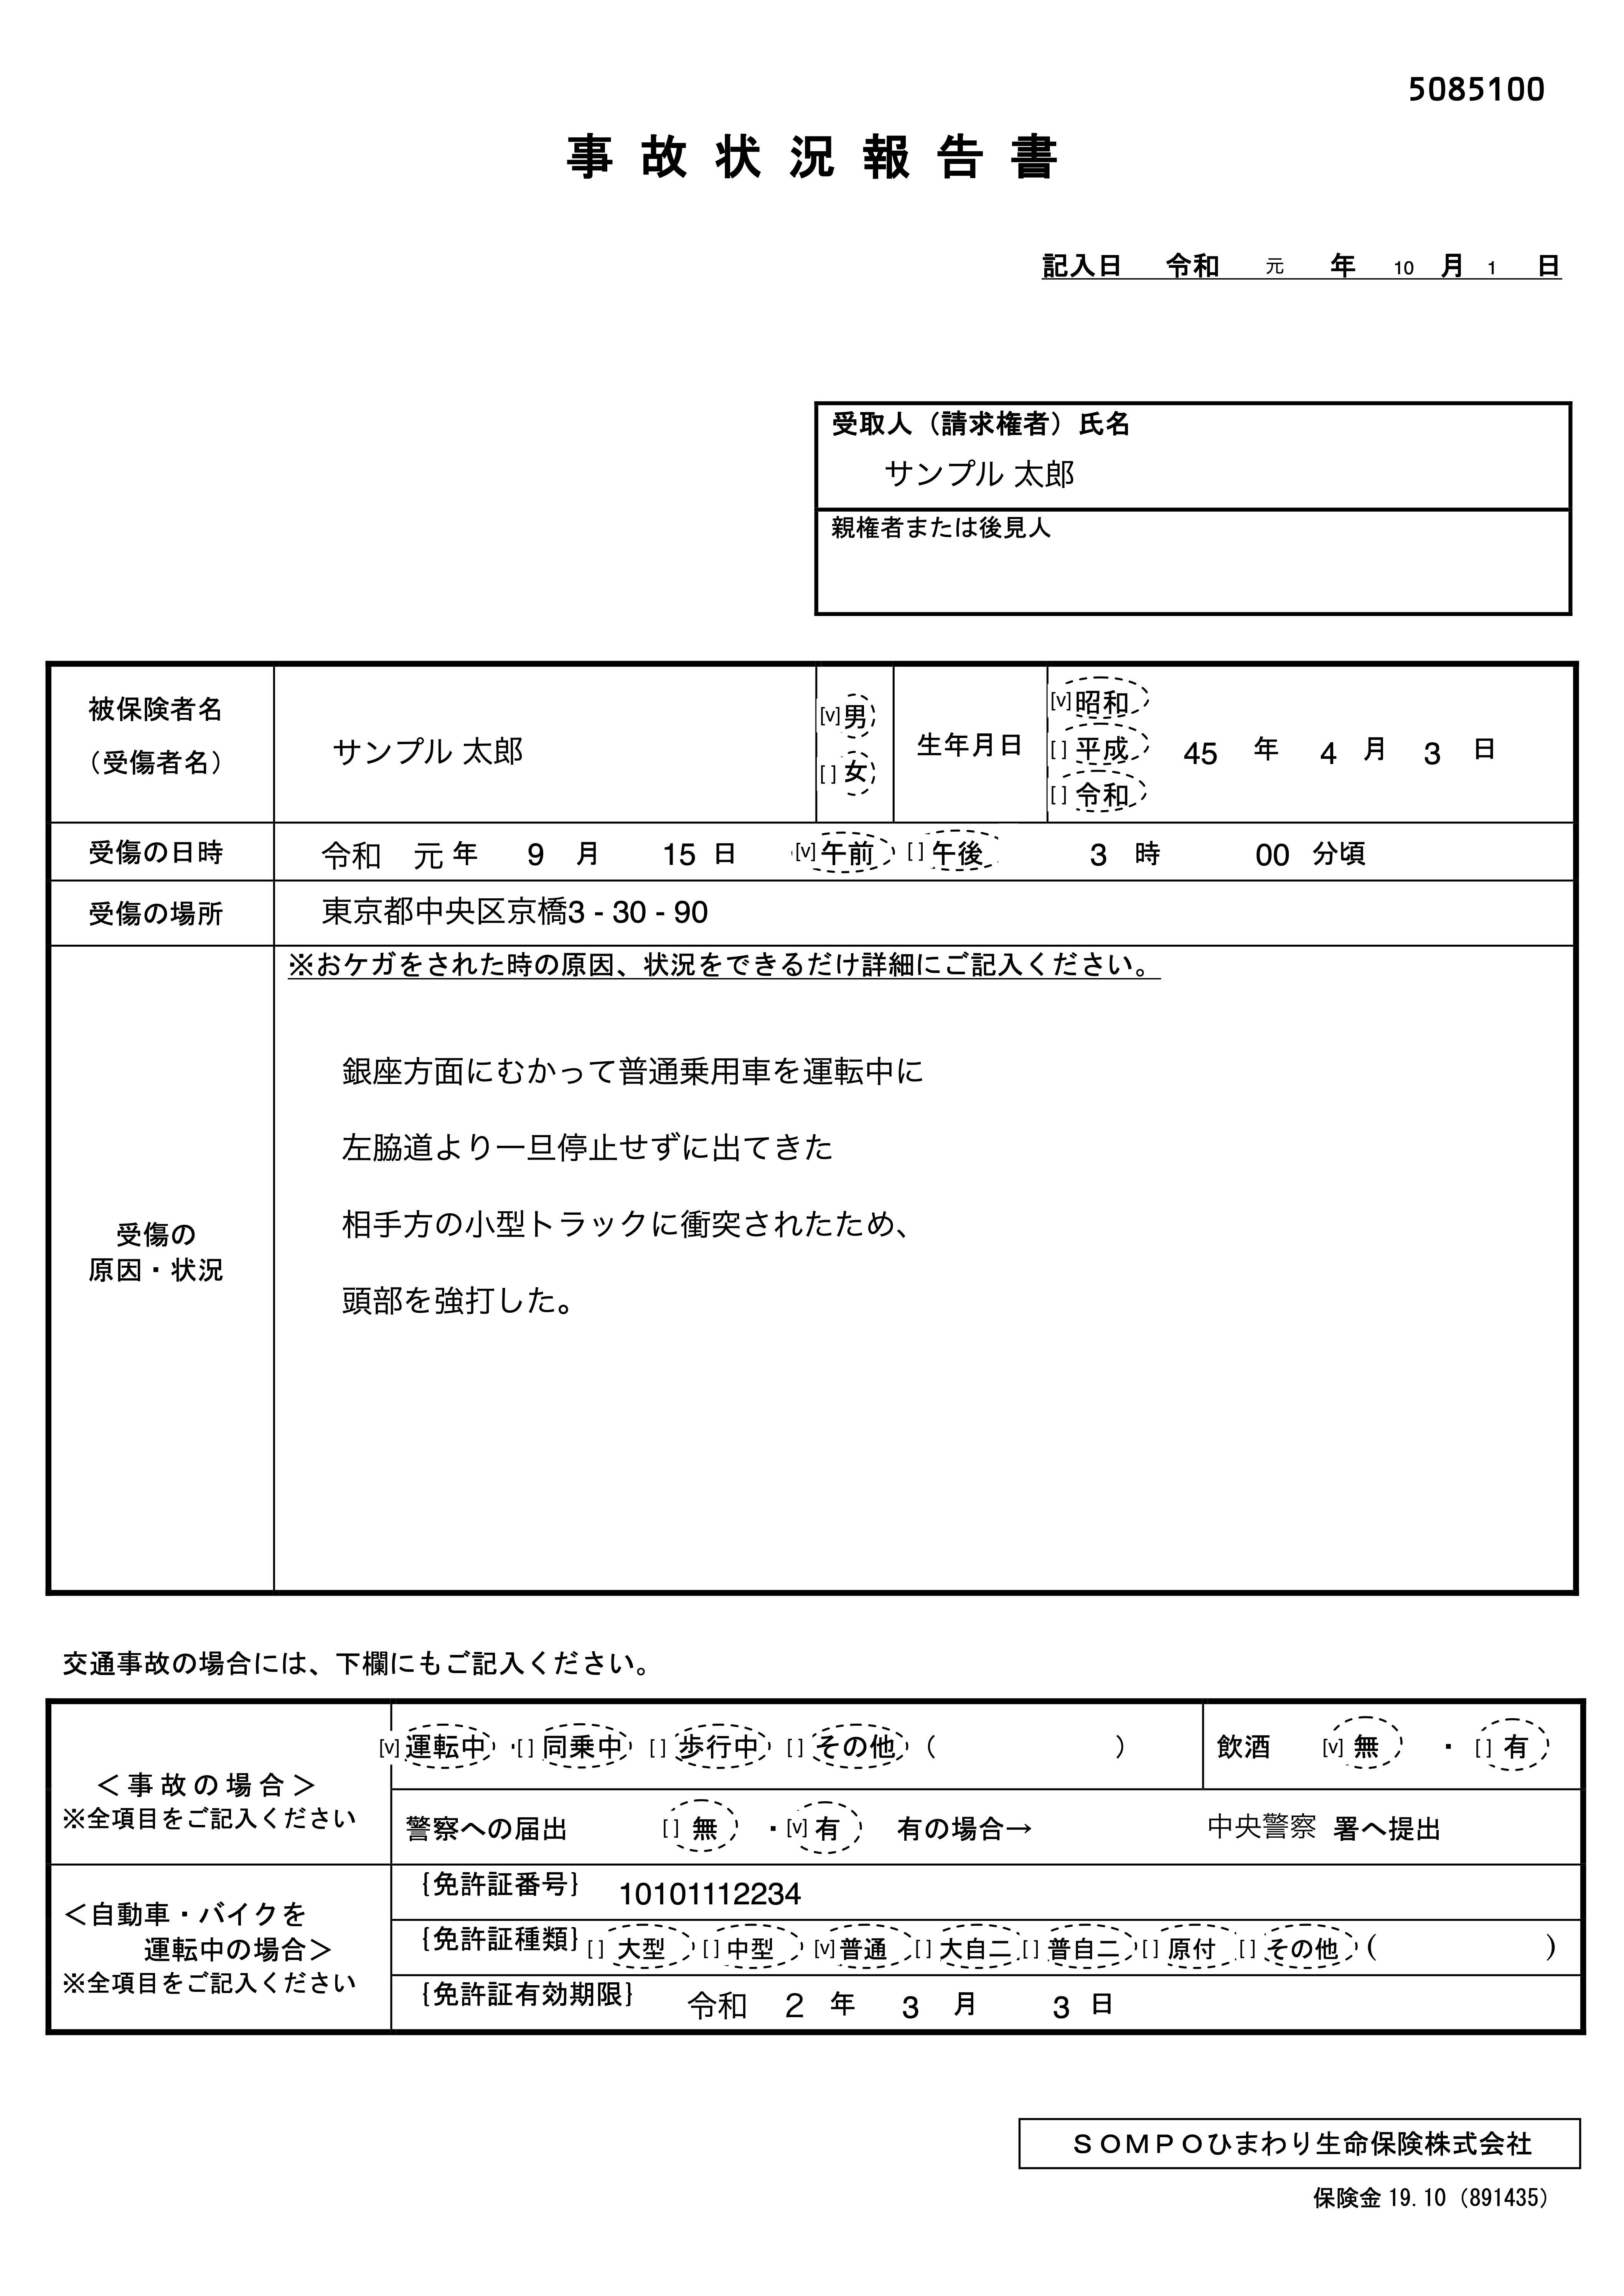


📋 Document Parse中...


weave: 🍩 https://wandb.ai/nhandsome/UPSTAGE-HANDSON-STEP3-NEW/r/call/0199e2b4-4d8b-7198-a8a9-9a5bed6f624c



🧠 LLM応答を生成中...


weave: 🍩 https://wandb.ai/nhandsome/UPSTAGE-HANDSON-STEP3-NEW/r/call/0199e2b4-686d-7f2f-a28e-db36556340c9



📦 JSON抽出中...

✅ 抽出結果（JSON）：
{
  "受傷者名前": "サンプル 太郎",
  "受傷者性別": "男",
  "受傷者生年月日": "1970/04/03",
  "受傷者住所": "記載無し",
  "受傷の日時": {
    "日付": "2019/09/15",
    "時間": "15:00"
  },
  "受傷の場所": "東京都中央区京橋3 - 30 - 90",
  "受傷の原因": "左脇道より一旦停止せずに出てきた相手方の小型トラックに衝突された",
  "受傷の内容": "頭部を強打した",
  "飲酒の有無": "無",
  "警察の届出": {
    "有無": "有",
    "警察署名": "中央警察署"
  },
  "免許証番号": "10101112234",
  "免許証種類": "普通",
  "免許有効期間": "2020/03/03"
}

📄 抽出結果:
{'受傷者名前': 'サンプル 太郎', '受傷者性別': '男', '受傷者生年月日': '1970/04/03', '受傷者住所': '記載無し', '受傷の日時': {'日付': '2019/09/15', '時間': '15:00'}, '受傷の場所': '東京都中央区京橋3 - 30 - 90', '受傷の原因': '左脇道より一旦停止せずに出てきた相手方の小型トラックに衝突された', '受傷の内容': '頭部を強打した', '飲酒の有無': '無', '警察の届出': {'有無': '有', '警察署名': '中央警察署'}, '免許証番号': '10101112234', '免許証種類': '普通', '免許有効期間': '2020/03/03'}


weave: 🍩 https://wandb.ai/nhandsome/UPSTAGE-HANDSON-STEP3-NEW/r/call/0199e2b4-7abc-75a9-b671-3d3d1efd95c8


In [2]:
# ======================================================
# 🪜 Step ① 解析対象ファイルの定義
# ======================================================
sample_files = [
    "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
]
sample_file = sample_files[0]

# ======================================================
# 🪜 Step ② ファイルに対する情報抽出処理
# ------------------------------------------------------
# - process_document_pipeline() により
#   ① HTML解析 → ② 段階的プロンプト適用 → ③ JSON抽出
# ======================================================
result_json = process_document_pipeline(
    sample_file,
    prompt1=PROMPT_1,
    prompt2=PROMPT_2,
    prompt3=PROMPT_3,
)

print("\n📄 抽出結果:")
print(result_json)


## 🧪 情報抽出結果の評価と改善サイクルの構築

### 🧠 背景
これまで、多様なテンプレートに対応しながら **担当者が必要とする情報のみを抽出するパイプライン** を構築し、初期的な実験を実施しました。  
（結果は [**「Upstage_HandsOn_2_ALL_Results」**](./Upstage_HandsOn_2_All_Results.ipynb) ファイルに記録）

しかし現状では――
- 抽出結果を一件ずつ人手で確認する必要がある  
- 作業負荷が高く、ヒューマンエラーのリスクもある  

一方で、モデルの精度向上には **評価データの整備** と **抽出結果との正確な比較** が不可欠です。  
そこで、**Weave の Evaluate 機能** を活用して、評価プロセスを仕組み化します。

---

## 🪜 Step ① 評価データ（正解ラベル）の作成
- 抽出精度の検証には、まず「正解」となるデータが必要。
- 既存のデータセット、もしくは担当者の業務要件に基づき作成可能。
- 事前に **評価対象項目** と **形式** を明確に定義することで、後続の自動比較がスムーズになる。

📌 例：  
- 日付 → `YYYY/MM/DD`  
- 住所 → 都道府県・市区町村レベルまで  
- 数値 → 単位込み or 単位なしを統一  



In [ ]:
# ======================================================
# 📝 1. 正解ラベル（ターゲットデータ）
# ------------------------------------------------------
# ※ ここは自由にカスタマイズ可能
# ======================================================
label = {
    "受傷者名前": "サンプル 太郎",
    "受傷者性別": "男",
    "受傷者生年月日": "1970/04/03",
    "受傷者住所": "記載無し",
    "受傷の日時": {"日付": "2019/09/15", "時間": "15:00"},
    "受傷の場所": "東京都中央区京橋3-30-90",
    "受傷の原因": "左脇道より一旦停止せずに出てきた相手方の小型トラックに衝突",
    "受傷の内容": "頭部を強打",
    "飲酒の有無": "無",
    "警察の届出": {"有無": "有", "警察署名": "中央警察署"},
    "免許証番号": "10101112234",     # 免許証番号が妥当かどうか
    "免許証種類": "普通",
    "免許有効期間": "2020/03/03"    # 切れている免許ではないか
}

# ======================================================
# 🧾 2. データセットの整形
# ------------------------------------------------------
# LLMの出力 result_json と正解データ label を比較するために、
# 各項目（キー）ごとに評価対象をフラットなリスト化する
# ======================================================
dataset = []

# シンプルなキー（文字列値を直接比較）
for k in ["受傷者名前", "受傷者性別", "受傷者住所", "受傷者生年月日",
          "受傷の場所", "受傷の原因", "受傷の内容",
          "飲酒の有無", "免許証番号", "免許証種類", "免許有効期間"]:
    dataset.append({
        "id": k,
        "pred": result_json[k],   # 予測値
        "target": label[k]        # 正解値
    })

# ネストされたキー（例：受傷の日時、警察の届出）は個別項目として展開
dataset.extend([
    {"id": "受傷の日時/日付", "pred": result_json["受傷の日時"]["日付"], "target": label["受傷の日時"]["日付"]},
    {"id": "受傷の日時/時間", "pred": result_json["受傷の日時"]["時間"], "target": label["受傷の日時"]["時間"]},
    {"id": "警察の届出/有無", "pred": result_json["警察の届出"]["有無"], "target": label["警察の届出"]["有無"]},
    {"id": "警察の届出/警察署名", "pred": result_json["警察の届出"]["警察署名"], "target": label["警察の届出"]["警察署名"]},
])

print(json.dumps(dataset, indent=2, ensure_ascii=False))

[
  {
    "id": "受傷者名前",
    "pred": "サンプル 太郎",
    "target": "サンプル 太郎"
  },
  {
    "id": "受傷者性別",
    "pred": "男",
    "target": "男"
  },
  {
    "id": "受傷者住所",
    "pred": "わからない",
    "target": "わからない"
  },
  {
    "id": "受傷者生年月日",
    "pred": "1970/04/03",
    "target": "1971年生まれ"
  },
  {
    "id": "受傷の場所",
    "pred": "東京都中央区京橋3 - 30 - 90",
    "target": "東京都中央区"
  },
  {
    "id": "受傷の原因",
    "pred": "左脇道より一旦停止せずに出てきた相手方の小型トラックに衝突された",
    "target": "小型トラックに衝突"
  },
  {
    "id": "受傷の内容",
    "pred": "頭部を強打した",
    "target": "頭部を強打"
  },
  {
    "id": "飲酒の有無",
    "pred": "無",
    "target": "無"
  },
  {
    "id": "免許証番号",
    "pred": "10101112234",
    "target": "1010-11122-34"
  },
  {
    "id": "免許証種類",
    "pred": "普通",
    "target": "普通"
  },
  {
    "id": "免許有効期間",
    "pred": "2020/03/03",
    "target": "2020年03月03日"
  },
  {
    "id": "受傷の日時/日付",
    "pred": "2019/09/15",
    "target": "2019年09月15日"
  },
  {
    "id": "受傷の日時/時間",
    "pred": "15:00",
    "target": "午後 1

## 🪜 Step ② 自動評価の仕組みを整える
- Weave の Evaluate 機能を活用し、**抽出結果と正解ラベルを自動で照合**。
- スコアリングロジックや評価基準をあらかじめ設定しておく。
- 評価対象ごとにカスタムスコアラーを用意することで柔軟な運用も可能。

📌 例：  
- 完全一致（Strict Match）  
- 意味類似度（Semantic Match）  
- 数値・日付など項目ごとの個別ルール対応

In [ ]:
# ======================================================
# 🧮 3. スコアラーの定義
# ------------------------------------------------------
# - match_scorer ：完全一致をチェック（主に数値・コード・短いテキスト向け）
# - EmbeddingSimilarityScorer ：意味的な類似度をチェック（原因や内容などに有効）
# ======================================================

@weave.op()
def match_scorer(output: str, target: str) -> dict:
    """
    📌 完全一致を判定するスコアラー
    - 前後の空白を除去して文字列を比較
    - 一致すれば correct=True
    """
    correct = (str(output).strip() == str(target).strip())
    return {"correct": correct}


# Embeddingベースの意味類似スコアラー
# threshold（類似度の閾値）は用途に応じて調整可能
if "OPENAI_API_KEY" in os.environ:
    print("EmbeddingSimilarityScorer 利用")
    from weave.scorers import EmbeddingSimilarityScorer
    similarity_scorer = EmbeddingSimilarityScorer(
        model_id="openai/text-embedding-3-small",
        threshold=0.6,
        column_map={"target": "target"}
    )
    scorers = [match_scorer, similarity_scorer]
else:
    scorers = [match_scorer]

# ======================================================
# 🧭 4. Evaluation設定
# ------------------------------------------------------
# OPENAI_API_KEYが設定されている場合のみ
# 意味類似スコアラーを追加で利用
# ======================================================
evaluation = weave.Evaluation(
    dataset=dataset,
    scorers=scorers,
)

# ======================================================
# 🧪 5. ダミーモデル定義
# ------------------------------------------------------
# weave.Modelを継承してpredictメソッドを実装
# 今回は LLM 出力（pred）をそのまま返すだけ
# ======================================================
class DummyModel(weave.Model):
    @weave.op()
    def predict(self, id: str, pred: str, target: str):
        """
        ここではモデルロジックは不要なので、
        予測値 pred をそのまま返す
        """
        return pred
model = DummyModel()

EmbeddingSimilarityScorer 利用


## 🪜 Step ③ 結果の可視化と改善ポイントの特定
- Evaluate 実行後、Weave 上で **スコア・差分** が自動生成される。
- 抽出漏れや誤抽出箇所を定量的に把握できる。
- 特定の項目で精度が低い場合、プロンプトや抽出ロジックをピンポイントに改善可能。

📊 期待される出力例：
- 項目別スコア
- 差分リスト
- 精度向上の余地がある箇所の特定


In [11]:
# ======================================================
# 🏁 6. 評価実行
# ------------------------------------------------------
# 各項目ごとに match_scorer / similarity_scorer でスコアを計算
# 結果はWeave上でも可視化・分析可能
# ======================================================
await evaluation.evaluate(model)

weave: Evaluated 1 of 15 examples
weave: Evaluated 2 of 15 examples
weave: Evaluated 3 of 15 examples
weave: Evaluated 4 of 15 examples
weave: Evaluated 5 of 15 examples
weave: Evaluated 6 of 15 examples
weave: Evaluated 7 of 15 examples
weave: Evaluated 8 of 15 examples
weave: Evaluated 9 of 15 examples
weave: Evaluated 10 of 15 examples
weave: Evaluated 11 of 15 examples
weave: Evaluated 12 of 15 examples
weave: Evaluated 13 of 15 examples
weave: Evaluated 14 of 15 examples
weave: Evaluated 15 of 15 examples
weave: Evaluation summary {
weave:   "match_scorer": {
weave:     "correct": {
weave:       "true_count": 7,
weave:       "true_fraction": 0.4666666666666667
weave:     }
weave:   },
weave:   "EmbeddingSimilarityScorer": {
weave:     "similarity_score": {
weave:       "mean": 0.8525211495176854
weave:     },
weave:     "is_similar": {
weave:       "true_count": 14,
weave:       "true_fraction": 0.9333333333333333
weave:     }
weave:   },
weave:   "model_latency": {
weave:     "me

{'match_scorer': {'correct': {'true_count': 7,
   'true_fraction': 0.4666666666666667}},
 'EmbeddingSimilarityScorer': {'similarity_score': {'mean': 0.8525211495176854},
  'is_similar': {'true_count': 14, 'true_fraction': 0.9333333333333333}},
 'model_latency': {'mean': 0.01582338015238444}}

## ✅ まとめ

| 工夫                             | 内容                                       | メリット                                 |
|----------------------------------|--------------------------------------------|------------------------------------------|
| 評価データ（正解ラベル）の事前作成 | 担当者の業務要件に沿ったラベルを用意          | 再現性・信頼性の高い評価が可能             |
| 自動比較の仕組み化               | 抽出結果と正解ラベルを自動で照合              | 人手確認を削減し、ミスを防止               |
| 評価結果の可視化                 | スコア・グラフ・差分を自動表示               | 改善ポイントを明確化し、継続的な改善が可能 |


- **人手による確認を自動化** し、検証コストを削減  
- **評価の再現性・客観性** を担保することでモデル改善が進めやすくなる  
- 自動評価基盤を整えることで、情報抽出モデルの **改善サイクルを高速化** できる 🚀
